# Travaux pratiques de problèmes inverses en génie civil



Vous êtes un(e) doctorant(e) intelligent(e), pleins d'avenir. On vous demande de déterminer le modèle dynamique du compateur. 
Les équations du modèle direct sont
$$ \ddot{q} = \frac{\Gamma - rForce}{2zz} $$
$$ \gamma =  \frac{F}{m} $$
$$ F = f_v v + f_s sign(v)$$


 $\gamma$ est l'accélération du centre de gravité. $v$ est la vitesse du compacteur. $r$ est le rayon des billes.  $\ddot{q}$ est l'accélération articulaire des deux billes du compacteur. $\Gamma$ est le couple délivré par le moteur hydraulique et réparti sur les deux billes. Les paramètres inconnus sont :
* $m$, la masse  du compacteur.
* $f_v$, le frottement visqueux
* $f_s$, le frottement sec
* $zz$ l'inertie de la bille avant qui est égale à l'inertie de la bille arrière





$$ \gamma =  \frac{f_v v + f_s }{f + 2} $$


Il vous est fourni :

* $\Gamma$ le couple mesuré (appelé couple_mesuré dans le code python)

* $q$ la vitesse articulaire (appelé q)

* $r$ le rayon des roues (appel r)

échantilllonné à 100 Hz (T=0,01s) sur une trajectoire usuelle du compacteur.

A partir de ces informations, trouver $m$, $f_v$, $f_s$, $zz$

In [11]:
import numpy as np
from experiences import experience1
couple_mesure, q, T, r = experience1()


Facile !

    Contruison le problème inverse : comment s'écrit la force en fonction des positions, vitesses et accélération et des paramètres. 

$F = \left(\gamma \ v \ 1 \  \ddot{q} \right)\cdot \left( \begin{array}{c} m \\ f_v \\ f_s \\ zz \end{array} \right) + b$

$b$ est un bruit. 

Le problème est sous la forme
$$ Y =W \cdot X + b$$

si le bruit est normal, l'estimateur sans biais de variance minimale est 

$$ \hat{X} = (W^tW)^{-1}W^tY$$

Il faut calculer W et donc, $v$, $\gamma$. Nous utilisons
$$ v = r\dot{q}$$
$$ \gamma=r\ddot{q}$$
$$ F=r\Gamma$$

Pour calculer $\dot{q}$ et $\ddot{q}$, nous faisons une différence finie centrée autant de fois que  nécessaire en suivant le schéma numérique suivant.

$$ dx(n) =  \frac{x(n+1)-x(n-1)}{2T}$$

$dx(n)$ est la dérivée numérique de $x(n)$.

In [12]:
# calcul des vitesses et accélération d
dq=(q[2:]-q[:-2])/(2*T)
ddq=(dq[2:]-dq[:-2])/(2*T)

# tous les signaux sont mis à la même taille
dq=dq[1:-1]
couple_mesure = couple_mesure[2:-2]

In [13]:
# calcul de W et Y
W = np.transpose([r*ddq, r*dq,np.ones(np.size(dq)), 2*ddq])
Y=np.transpose(couple_mesure/r)
#

In [14]:
# résolution par moindres carrés
# nous utilisons la librairie linalg
X=np.linalg.lstsq(W,Y)[0]

In [15]:
print('La masse du compacteur est {:.10f}'.format(
      X[0]))
print('Le frottement visqueux {:.10f}'.format(
      X[1]))
print('Le frottement sec est {:.10f}'.format(
      X[2]))
print('L'' inertie des billes est  {:.10f}'.format(
      X[3]))


La masse du compacteur est -280616448380379.9687500000
Le frottement visqueux 43.8437500000
Le frottement sec est 1020.5729517937
L inertie des billes est  94708051328378.2187500000


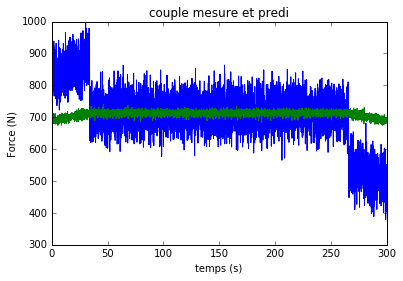

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline 
couple_predit=np.transpose(W.dot(X))*r

nech=np.size(Y)
temps=T*np.arange(1,nech+1)
plt.figure(1)
plt.plot(temps, couple_mesure, temps, couple_predit)
plt.title('couple mesure et predi')
plt.xlabel('temps (s)')
plt.ylabel('Force (N)')

<img src="dragon_colere.png" />

Vous avis commis de multiples erreurs que nous pouvons classer en trois catégories (selon Nicholas Taieb, les cygnes noirs) :
  * erreur de narration (mind projection fallacy)
  * erreur ludique 
  * erreur de confirmation


In [17]:
np.save('W',W=W)

TypeError: save() got an unexpected keyword argument 'W'

ValueError: too many values to unpack (expected 2)